
<img src="http://wyeside.co.uk/event-assets/images/avengers-endgame-20190401025200-tmdb5jqncbp8.jpg" width="800"></img>

<br>

# TMDB Box Office Prediction

<h3> Simple, Without External Files, EDA</h3>




# Table of Contents:

**1. [Problem Definition](#id1)** <br>
**2. [Get the Data (Collect / Obtain)](#id2)** <br>
**3. [Load the Dataset](#id3)** <br>
**4. [Data Pre-processing](#id4)** <br>
**5. [Model](#id5)** <br>
**6. [Visualization and Analysis of Results](#id6)** <br>
**7. [Submittion](#id7)** <br>
**8. [References](#ref)** <br>

<a id="id1"></a> <br> 
# **1. Problem Definition:** 

In a world... where movies made an estimated $41.7 billion in 2018, the film industry is more popular than ever. But what movies make the most money at the box office? How much does a director matter? Or the budget? For some movies, it's "You had me at 'Hello.'" For others, the trailer falls short of expectations and you think "What we have here is a failure to communicate."

In this competition, you're presented with metadata on over 7,000 past films from The Movie Database to try and predict their overall worldwide box office revenue. Data points provided include cast, crew, plot keywords, budget, posters, release dates, languages, production companies, and countries. You can collect other publicly available data to use in your model predictions, but in the spirit of this competition, use only data that would have been available before a movie's release.

<a id="id2"></a> <br> 
# **2. Get the Data (Collect / Obtain):** 


In [1]:
import numpy as np 
import pandas as pd 
import ast
from tqdm import tqdm
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import normalize
import xgboost as xgb
import lightgbm as lgb
import catboost as cat
import matplotlib.pyplot as plt
import seaborn as sns 
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import os
print(os.listdir("../input"))
random_seed = 0
def rmse(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

ModuleNotFoundError: No module named 'xgboost'

<a id="id3"></a> <br> 
# **3. Load the Dataset** 
<h3>3.1 Heads of the data</h3><br>

In [2]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
train.index = train['id']
test.index = test['id']

In [3]:
print("Train : " + str(train.shape))
print("Teset : "+ str(test.shape))

Train : (3000, 23)
Teset : (4398, 22)


In [4]:
train.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
id,,,,,,,,,,,,,,,,,,,,,,,
1,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
2,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
3,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,/lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg,"[{'name': 'Bold Films', 'id': 2266}, {'name': ...","[{'iso_3166_1': 'US', 'name': 'United States o...",10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000
4,4,NaN,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,/aTXRaPrWSinhcmCrcfJK17urp3F.jpg,NaN,"[{'iso_3166_1': 'IN', 'name': 'India'}]",3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000
5,5,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,/m22s7zvkVFDU9ir56PiiqIEWFdT.jpg,NaN,"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,NaN,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970


In [5]:
print("Types columns : \n" + str(train.dtypes))

Types columns : 
id                         int64
belongs_to_collection     object
budget                     int64
genres                    object
homepage                  object
imdb_id                   object
original_language         object
original_title            object
overview                  object
popularity               float64
poster_path               object
production_companies      object
production_countries      object
release_date              object
runtime                  float64
spoken_languages          object
status                    object
tagline                   object
title                     object
Keywords                  object
cast                      object
crew                      object
revenue                    int64
dtype: object


In [6]:
train.isna().sum().sort_values(ascending=False)

belongs_to_collection    2396
homepage                 2054
tagline                   597
Keywords                  276
production_companies      156
production_countries       55
spoken_languages           20
crew                       16
cast                       13
overview                    8
genres                      7
runtime                     2
poster_path                 1
original_language           0
budget                      0
imdb_id                     0
revenue                     0
original_title              0
popularity                  0
release_date                0
status                      0
title                       0
id                          0
dtype: int64

## Cheking for missing or null values

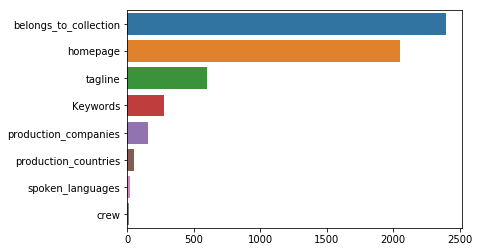

In [7]:
missing=train.isna().sum().sort_values(ascending=False)
sns.barplot(missing[:8],missing[:8].index)
plt.show()

Let's investigate all NaN Values:
- belongs_to_collection    2396
- homepage                 2054
- tagline                   597
- Keywords                  276
- production_companies      156
- production_countries       55
- spoken_languages           20
- crew                       16
- cast                       13
- overview                    8
- genres                      7
- runtime                     2
- poster_path                 1


In [8]:
train['belongs_to_collection'][:5]

id
1    [{'id': 313576, 'name': 'Hot Tub Time Machine ...
2    [{'id': 107674, 'name': 'The Princess Diaries ...
3                                                  NaN
4                                                  NaN
5                                                  NaN
Name: belongs_to_collection, dtype: object

In [9]:
train['homepage'][:5]

id
1                                  NaN
2                                  NaN
3    http://sonyclassics.com/whiplash/
4           http://kahaanithefilm.com/
5                                  NaN
Name: homepage, dtype: object

In [10]:
train['tagline'][:5]

id
1    The Laws of Space and Time are About to be Vio...
2    It can take a lifetime to find true love; she'...
3      The road to greatness can take you to the edge.
4                                                  NaN
5                                                  NaN
Name: tagline, dtype: object

In [11]:
train['Keywords'][:5]

id
1    [{'id': 4379, 'name': 'time travel'}, {'id': 9...
2    [{'id': 2505, 'name': 'coronation'}, {'id': 42...
3    [{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...
4    [{'id': 10092, 'name': 'mystery'}, {'id': 1054...
5                                                  NaN
Name: Keywords, dtype: object

In [12]:
train['production_companies'][:5]

id
1    [{'name': 'Paramount Pictures', 'id': 4}, {'na...
2          [{'name': 'Walt Disney Pictures', 'id': 2}]
3    [{'name': 'Bold Films', 'id': 2266}, {'name': ...
4                                                  NaN
5                                                  NaN
Name: production_companies, dtype: object

In [13]:
train['production_countries'][:5]

id
1    [{'iso_3166_1': 'US', 'name': 'United States o...
2    [{'iso_3166_1': 'US', 'name': 'United States o...
3    [{'iso_3166_1': 'US', 'name': 'United States o...
4              [{'iso_3166_1': 'IN', 'name': 'India'}]
5        [{'iso_3166_1': 'KR', 'name': 'South Korea'}]
Name: production_countries, dtype: object

In [14]:
train['spoken_languages'][:5]

id
1             [{'iso_639_1': 'en', 'name': 'English'}]
2             [{'iso_639_1': 'en', 'name': 'English'}]
3             [{'iso_639_1': 'en', 'name': 'English'}]
4    [{'iso_639_1': 'en', 'name': 'English'}, {'iso...
5             [{'iso_639_1': 'ko', 'name': '한국어/조선말'}]
Name: spoken_languages, dtype: object

In [15]:
train['crew'][:5]

id
1    [{'credit_id': '59ac067c92514107af02c8c8', 'de...
2    [{'credit_id': '52fe43fe9251416c7502563d', 'de...
3    [{'credit_id': '54d5356ec3a3683ba0000039', 'de...
4    [{'credit_id': '52fe48779251416c9108d6eb', 'de...
5    [{'credit_id': '52fe464b9251416c75073b43', 'de...
Name: crew, dtype: object

In [16]:
train['cast'][:5]

id
1    [{'cast_id': 4, 'character': 'Lou', 'credit_id...
2    [{'cast_id': 1, 'character': 'Mia Thermopolis'...
3    [{'cast_id': 5, 'character': 'Andrew Neimann',...
4    [{'cast_id': 1, 'character': 'Vidya Bagchi', '...
5    [{'cast_id': 3, 'character': 'Chun-soo', 'cred...
Name: cast, dtype: object

In [17]:
train['overview'][:5]

id
1    When Lou, who has become the "father of the In...
2    Mia Thermopolis is now a college graduate and ...
3    Under the direction of a ruthless instructor, ...
4    Vidya Bagchi (Vidya Balan) arrives in Kolkata ...
5    Marine Boy is the story of a former national s...
Name: overview, dtype: object

In [18]:
train['genres'][:5]

id
1                       [{'id': 35, 'name': 'Comedy'}]
2    [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...
3                        [{'id': 18, 'name': 'Drama'}]
4    [{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...
5    [{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...
Name: genres, dtype: object

In [19]:
train['runtime'][:5]


id
1     93.0
2    113.0
3    105.0
4    122.0
5    118.0
Name: runtime, dtype: float64

In [20]:
train['poster_path'][:5]

id
1    /tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg
2    /w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg
3    /lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg
4    /aTXRaPrWSinhcmCrcfJK17urp3F.jpg
5    /m22s7zvkVFDU9ir56PiiqIEWFdT.jpg
Name: poster_path, dtype: object

In [21]:
train.loc[train['id'] == 16,'revenue'] = 192864         
train.loc[train['id'] == 90,'budget'] = 30000000                  
train.loc[train['id'] == 118,'budget'] = 60000000       
train.loc[train['id'] == 149,'budget'] = 18000000       
train.loc[train['id'] == 313,'revenue'] = 12000000       
train.loc[train['id'] == 451,'revenue'] = 12000000      
train.loc[train['id'] == 464,'budget'] = 20000000       
train.loc[train['id'] == 470,'budget'] = 13000000       
train.loc[train['id'] == 513,'budget'] = 930000         
train.loc[train['id'] == 797,'budget'] = 8000000        
train.loc[train['id'] == 819,'budget'] = 90000000       
train.loc[train['id'] == 850,'budget'] = 90000000       
train.loc[train['id'] == 1007,'budget'] = 2              
train.loc[train['id'] == 1112,'budget'] = 7500000       
train.loc[train['id'] == 1131,'budget'] = 4300000        
train.loc[train['id'] == 1359,'budget'] = 10000000       
train.loc[train['id'] == 1542,'budget'] = 1             
train.loc[train['id'] == 1570,'budget'] = 15800000       
train.loc[train['id'] == 1571,'budget'] = 4000000        
train.loc[train['id'] == 1714,'budget'] = 46000000       
train.loc[train['id'] == 1721,'budget'] = 17500000       
train.loc[train['id'] == 1865,'revenue'] = 25000000      
train.loc[train['id'] == 1885,'budget'] = 12             
train.loc[train['id'] == 2091,'budget'] = 10             
train.loc[train['id'] == 2268,'budget'] = 17500000       
train.loc[train['id'] == 2491,'budget'] = 6              
train.loc[train['id'] == 2602,'budget'] = 31000000       
train.loc[train['id'] == 2612,'budget'] = 15000000       
train.loc[train['id'] == 2696,'budget'] = 10000000      
train.loc[train['id'] == 2801,'budget'] = 10000000       
train.loc[train['id'] == 335,'budget'] = 2 
train.loc[train['id'] == 348,'budget'] = 12
train.loc[train['id'] == 470,'budget'] = 13000000 
train.loc[train['id'] == 513,'budget'] = 1100000
train.loc[train['id'] == 640,'budget'] = 6 
train.loc[train['id'] == 696,'budget'] = 1
train.loc[train['id'] == 797,'budget'] = 8000000 
train.loc[train['id'] == 850,'budget'] = 1500000
train.loc[train['id'] == 1199,'budget'] = 5 
train.loc[train['id'] == 1282,'budget'] = 9              
train.loc[train['id'] == 1347,'budget'] = 1
train.loc[train['id'] == 1755,'budget'] = 2
train.loc[train['id'] == 1801,'budget'] = 5
train.loc[train['id'] == 1918,'budget'] = 592 
train.loc[train['id'] == 2033,'budget'] = 4
train.loc[train['id'] == 2118,'budget'] = 344 
train.loc[train['id'] == 2252,'budget'] = 130
train.loc[train['id'] == 2256,'budget'] = 1 
train.loc[train['id'] == 2696,'budget'] = 10000000

In [22]:
test.loc[test['id'] == 3033,'budget'] = 250 
test.loc[test['id'] == 3051,'budget'] = 50
test.loc[test['id'] == 3084,'budget'] = 337
test.loc[test['id'] == 3224,'budget'] = 4  
test.loc[test['id'] == 3594,'budget'] = 25  
test.loc[test['id'] == 3619,'budget'] = 500  
test.loc[test['id'] == 3831,'budget'] = 3  
test.loc[test['id'] == 3935,'budget'] = 500  
test.loc[test['id'] == 4049,'budget'] = 995946 
test.loc[test['id'] == 4424,'budget'] = 3  
test.loc[test['id'] == 4460,'budget'] = 8  
test.loc[test['id'] == 4555,'budget'] = 1200000 
test.loc[test['id'] == 4624,'budget'] = 30 
test.loc[test['id'] == 4645,'budget'] = 500 
test.loc[test['id'] == 4709,'budget'] = 450 
test.loc[test['id'] == 4839,'budget'] = 7
test.loc[test['id'] == 3125,'budget'] = 25 
test.loc[test['id'] == 3142,'budget'] = 1
test.loc[test['id'] == 3201,'budget'] = 450
test.loc[test['id'] == 3222,'budget'] = 6
test.loc[test['id'] == 3545,'budget'] = 38
test.loc[test['id'] == 3670,'budget'] = 18
test.loc[test['id'] == 3792,'budget'] = 19
test.loc[test['id'] == 3881,'budget'] = 7
test.loc[test['id'] == 3969,'budget'] = 400
test.loc[test['id'] == 4196,'budget'] = 6
test.loc[test['id'] == 4221,'budget'] = 11
test.loc[test['id'] == 4222,'budget'] = 500
test.loc[test['id'] == 4285,'budget'] = 11
test.loc[test['id'] == 4319,'budget'] = 1
test.loc[test['id'] == 4639,'budget'] = 10
test.loc[test['id'] == 4719,'budget'] = 45
test.loc[test['id'] == 4822,'budget'] = 22
test.loc[test['id'] == 4829,'budget'] = 20
test.loc[test['id'] == 4969,'budget'] = 20
test.loc[test['id'] == 5021,'budget'] = 40 
test.loc[test['id'] == 5035,'budget'] = 1 
test.loc[test['id'] == 5063,'budget'] = 14 
test.loc[test['id'] == 5119,'budget'] = 2 
test.loc[test['id'] == 5214,'budget'] = 30 
test.loc[test['id'] == 5221,'budget'] = 50 
test.loc[test['id'] == 4903,'budget'] = 15
test.loc[test['id'] == 4983,'budget'] = 3
test.loc[test['id'] == 5102,'budget'] = 28
test.loc[test['id'] == 5217,'budget'] = 75
test.loc[test['id'] == 5224,'budget'] = 3 
test.loc[test['id'] == 5469,'budget'] = 20 
test.loc[test['id'] == 5840,'budget'] = 1 
test.loc[test['id'] == 5960,'budget'] = 30
test.loc[test['id'] == 6506,'budget'] = 11 
test.loc[test['id'] == 6553,'budget'] = 280
test.loc[test['id'] == 6561,'budget'] = 7
test.loc[test['id'] == 6582,'budget'] = 218
test.loc[test['id'] == 6638,'budget'] = 5
test.loc[test['id'] == 6749,'budget'] = 8 
test.loc[test['id'] == 6759,'budget'] = 50 
test.loc[test['id'] == 6856,'budget'] = 10
test.loc[test['id'] == 6858,'budget'] =  100
test.loc[test['id'] == 6876,'budget'] =  250
test.loc[test['id'] == 6972,'budget'] = 1
test.loc[test['id'] == 7079,'budget'] = 8000000
test.loc[test['id'] == 7150,'budget'] = 118
test.loc[test['id'] == 6506,'budget'] = 118
test.loc[test['id'] == 7225,'budget'] = 6
test.loc[test['id'] == 7231,'budget'] = 85
test.loc[test['id'] == 5222,'budget'] = 5
test.loc[test['id'] == 5322,'budget'] = 90
test.loc[test['id'] == 5350,'budget'] = 70
test.loc[test['id'] == 5378,'budget'] = 10
test.loc[test['id'] == 5545,'budget'] = 80
test.loc[test['id'] == 5810,'budget'] = 8
test.loc[test['id'] == 5926,'budget'] = 300
test.loc[test['id'] == 5927,'budget'] = 4
test.loc[test['id'] == 5986,'budget'] = 1
test.loc[test['id'] == 6053,'budget'] = 20
test.loc[test['id'] == 6104,'budget'] = 1
test.loc[test['id'] == 6130,'budget'] = 30
test.loc[test['id'] == 6301,'budget'] = 150
test.loc[test['id'] == 6276,'budget'] = 100
test.loc[test['id'] == 6473,'budget'] = 100
test.loc[test['id'] == 6842,'budget'] = 30

<a id="id4"></a> <br> 
# **4. Data Pre-processing**  

In [23]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [24]:
train.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
id,,,,,,,,,,,,,,,,,,,,,,,
1,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
2,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
3,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,/lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg,"[{'name': 'Bold Films', 'id': 2266}, {'name': ...","[{'iso_3166_1': 'US', 'name': 'United States o...",10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000
4,4,NaN,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,/aTXRaPrWSinhcmCrcfJK17urp3F.jpg,NaN,"[{'iso_3166_1': 'IN', 'name': 'India'}]",3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000
5,5,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,/m22s7zvkVFDU9ir56PiiqIEWFdT.jpg,NaN,"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,NaN,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970


In [25]:
test.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew
id,,,,,,,,,,,,,,,,,,,,,,
3001,3001,"[{'id': 34055, 'name': 'Pokémon Collection', '...",0,"[{'id': 12, 'name': 'Adventure'}, {'id': 16, '...",http://www.pokemon.com/us/movies/movie-pokemon...,tt1226251,ja,ディアルガVSパルキアVSダークライ,Ash and friends (this time accompanied by newc...,3.851534,/tnftmLMemPLduW6MRyZE0ZUD19z.jpg,NaN,"[{'iso_3166_1': 'JP', 'name': 'Japan'}, {'iso_...",7/14/07,90.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Somewhere Between Time & Space... A Legend Is ...,Pokémon: The Rise of Darkrai,"[{'id': 11451, 'name': 'pok√©mon'}, {'id': 115...","[{'cast_id': 3, 'character': 'Tonio', 'credit_...","[{'credit_id': '52fe44e7c3a368484e03d683', 'de..."
3002,3002,NaN,88000,"[{'id': 27, 'name': 'Horror'}, {'id': 878, 'na...",NaN,tt0051380,en,Attack of the 50 Foot Woman,When an abused wife grows to giant size becaus...,3.559789,/9MgBNBqlH1sG4yG2u4XkwI5CoJa.jpg,"[{'name': 'Woolner Brothers Pictures Inc.', 'i...","[{'iso_3166_1': 'US', 'name': 'United States o...",5/19/58,65.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A titanic beauty spreads a macabre wave of hor...,Attack of the 50 Foot Woman,"[{'id': 9748, 'name': 'revenge'}, {'id': 9951,...","[{'cast_id': 2, 'character': 'Nancy Fowler Arc...","[{'credit_id': '55807805c3a3685b1300060b', 'de..."
3003,3003,NaN,0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",NaN,tt0118556,en,Addicted to Love,Good-natured astronomer Sam is devastated when...,8.085194,/ed6nD7h9sbojSWY2qrnDcSvDFko.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",5/23/97,100.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A Comedy About Lost Loves And Last Laughs,Addicted to Love,"[{'id': 931, 'name': 'jealousy'}, {'id': 9673,...","[{'cast_id': 11, 'character': 'Maggie', 'credi...","[{'credit_id': '52fe4330c3a36847f8041367', 'de..."
3004,3004,NaN,6800000,"[{'id': 18, 'name': 'Drama'}, {'id': 10752, 'n...",http://www.sonyclassics.com/incendies/,tt1255953,fr,Incendies,A mother's last wishes send twins Jeanne and S...,8.596012,/sEUG3qjxwHjxkzuO7plrRHhOZUH.jpg,"[{'name': 'TS Productions', 'id': 313}, {'name...","[{'iso_3166_1': 'CA', 'name': 'Canada'}, {'iso...",9/4/10,130.0,"[{'iso_639_1': 'fr', 'name': 'Français'}, {'is...",Released,The search began at the opening of their mothe...,Incendies,"[{'id': 378, 'name': 'prison'}, {'id': 539, 'n...","[{'cast_id': 6, 'character': 'Nawal', 'credit_...","[{'credit_id': '56478092c3a36826140043af', 'de..."
3005,3005,NaN,2000000,"[{'id': 36, 'name': 'History'}, {'id': 99, 'na...",NaN,tt0418753,en,Inside Deep Throat,"In 1972, a seemingly typical shoestring budget...",3.217680,/n4WC3zbelz6SG7rhkWbf8m9pMHB.jpg,NaN,"[{'iso_3166_1': 'US', 'name': 'United States o...",2/11/05,92.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It was filmed in 6 days for 25 thousand dollar...,Inside Deep Throat,"[{'id': 279, 'name': 'usa'}, {'id': 1228, 'nam...","[{'cast_id': 1, 'character': 'Narrator (voice)...","[{'credit_id': '52fe44ce9251416c75041967', 'de..."


In [26]:
train.describe()

,id,budget,popularity,runtime,revenue
count,3000.000000,3.000000e+03,3000.000000,2998.000000,3.000000e+03
mean,1500.500000,2.266135e+07,8.463274,107.856571,6.668176e+07
std,866.169729,3.702662e+07,12.104000,22.086434,1.375149e+08
min,1.000000,0.000000e+00,0.000001,0.000000,1.000000e+00
25%,750.750000,0.000000e+00,4.018053,94.000000,2.401550e+06
50%,1500.500000,8.000000e+06,7.374861,104.000000,1.680707e+07
75%,2250.250000,3.000000e+07,10.890983,118.000000,6.877599e+07
max,3000.000000,3.800000e+08,294.337037,338.000000,1.519558e+09


It is clear from the graph below that revenue depends a lot on budget and total_vote

In [27]:
train.columns.values

array(['id', 'belongs_to_collection', 'budget', 'genres', 'homepage',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'Keywords',
       'cast', 'crew', 'revenue'], dtype=object)

In [28]:
#Transform Text to Dictionary. Because these columns are in json format.
import ast
dict_columns = ['belongs_to_collection', 'genres', 'production_companies',
                'production_countries', 'spoken_languages', 'Keywords', 'cast', 'crew']

def text_to_dict(df):
    for column in dict_columns:
        df[column] = df[column].apply(lambda x: {} if pd.isna(x) else ast.literal_eval(x) )
    return df
        
dfx = text_to_dict(train)
for col in dict_columns:
    train[col]=dfx[col]

In [29]:
train.head(5)

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
id,,,,,,,,,,,,,,,,,,,,,,,
1,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
2,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
3,3,{},3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,/lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg,"[{'name': 'Bold Films', 'id': 2266}, {'name': ...","[{'iso_3166_1': 'US', 'name': 'United States o...",10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000
4,4,{},1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,/aTXRaPrWSinhcmCrcfJK17urp3F.jpg,{},"[{'iso_3166_1': 'IN', 'name': 'India'}]",3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000
5,5,{},0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,/m22s7zvkVFDU9ir56PiiqIEWFdT.jpg,{},"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,{},"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970


In [30]:
dfx = text_to_dict(test)
for col in dict_columns:
       test[col]=dfx[col]   

Text(0, 0.5, 'No of releases')

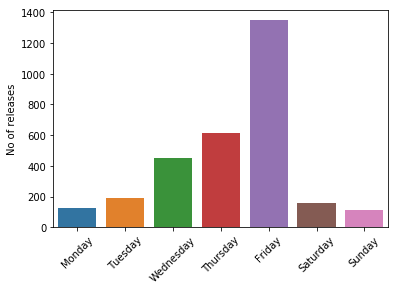

In [31]:
def date(x):
    x=str(x)
    year=x.split('/')[2]
    if int(year)<19:
        return x[:-2]+'20'+year
    else:
        return x[:-2]+'19'+year
    
train['release_date'] =train['release_date'].fillna('1/1/90').apply(lambda x: date(x))
test['release_date']  =test['release_date'].fillna('1/1/90').apply(lambda x: date(x))

#from datetime import datetime
train['release_date'] = train['release_date'].apply(lambda x: datetime.strptime(x,'%m/%d/%Y'))
test['release_date']  = test['release_date'].apply(lambda x: datetime.strptime(x,'%m/%d/%Y'))

train['release_day']   = train['release_date'].apply(lambda x:x.weekday())
train['release_month'] = train['release_date'].apply(lambda x:x.month)
train['release_year']  = train['release_date'].apply(lambda x:x.year)

test['release_day']   = test['release_date'].apply(lambda x:x.weekday())
test['release_month'] = test['release_date'].apply(lambda x:x.month)
test['release_year']  = test['release_date'].apply(lambda x:x.year)

day=train['release_day'].value_counts().sort_index()
sns.barplot(day.index,day)
plt.gca().set_xticklabels(["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"],rotation='45')
plt.ylabel('No of releases')

In [32]:
def data_preprocessing(df):
    df['belongs_to_collection']= df['belongs_to_collection'].apply(lambda x: 1 if x != {} else 0)
    df['has_homepage'] = 1
    df.loc[ pd.isnull(df['homepage']),'has_homepage'] = 0
    
    df['num_genres'] = df['genres'].apply(lambda x: len(x) if x != {} else 0)

    df['budget'] = np.log1p(df['budget'])
    df['isTaglineNA'] = df['tagline'].apply( lambda x: 0 if pd.isnull(x) else 1)
    df['original_language'] = le.fit_transform(df['original_language'])
    
    
    df['isOriginalLanguageEng'] = 0 
    df.loc[ df['original_language'].astype(str) == "en" ,"isOriginalLanguageEng"] = 1
    
    df['ismovie_released']=1
    df.loc[(df['status']!='Released'),'ismovie_released']=0
    
    df['no_spoken_languages']=df['spoken_languages'].apply(lambda x: len(x))
    df['original_title_letter_count'] = df['original_title'].str.len() 
    df['original_title_word_count'] = df['original_title'].str.split().str.len() 


    df['title_word_count'] = df['title'].str.split().str.len()
    df['overview_word_count'] = df['overview'].str.split().str.len()
    df['tagline_word_count'] = df['tagline'].str.split().str.len()
    
    
    df['production_countries_count'] = df['production_countries'].apply(lambda x : len(x))
    df['production_companies_count'] = df['production_companies'].apply(lambda x : len(x))
    df['cast_count'] = df['cast'].apply(lambda x : len(x))
    df['crew_count'] = df['crew'].apply(lambda x : len(x))
    
    
    #Gender
    df['genders_0_crew'] = df['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 0]))
    df['genders_1_crew'] = df['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 1]))
    df['genders_2_crew'] = df['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 2]))
    
    
    cols_to_normalize=['runtime','popularity','budget','_budget_runtime_ratio','_budget_year_ratio','_budget_popularity_ratio','_releaseYear_popularity_ratio',
    '_releaseYear_popularity_ratio2','_num_Keywords','_num_cast','no_spoken_languages','original_title_letter_count','original_title_word_count',
    'title_word_count','overview_word_count','tagline_word_count','production_countries_count','production_companies_count','cast_count','crew_count',
    'genders_0_crew','genders_1_crew','genders_2_crew']
    for col in cols_to_normalize:
        if (col in df):
            print(col)
            x_array=[]
            x_array=np.array(df[col].fillna(0))
            X_norm=normalize([x_array])[0]
            df[col]=X_norm
        
    
    df = df.drop(['homepage','tagline','poster_path','overview','genres',
                  'imdb_id','original_title','cast','Keywords','title',
                 'production_companies','production_countries',
                  'release_date','spoken_languages','crew','status'],axis=1)
    
    df.fillna(-1,inplace=True)
    return df

In [33]:
train.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue,release_day,release_month,release_year
id,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2015-02-20,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651,4,2,2015
2,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",2004-08-06,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435,4,8,2004
3,3,{},3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,/lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg,"[{'name': 'Bold Films', 'id': 2266}, {'name': ...","[{'iso_3166_1': 'US', 'name': 'United States o...",2014-10-10,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000,4,10,2014
4,4,{},1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,/aTXRaPrWSinhcmCrcfJK17urp3F.jpg,{},"[{'iso_3166_1': 'IN', 'name': 'India'}]",2012-03-09,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000,4,3,2012
5,5,{},0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,/m22s7zvkVFDU9ir56PiiqIEWFdT.jpg,{},"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",2009-02-05,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,{},"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970,3,2,2009


In [34]:
'''
#ref: https://www.kaggle.com/zero92/tmdb-prediction with some minors changes
def  data_preprocessing2(df):
    df['_budget_runtime_ratio'] = (df['budget']/df['runtime']).replace([np.inf,-np.inf,np.nan],0)
    df['_budget_popularity_ratio'] = df['budget']/df['popularity']
    df['_budget_year_ratio'] = df['budget'].fillna(0)/(df['release_year']*df['release_year'])
    df['_releaseYear_popularity_ratio'] = df['release_year']/df['popularity']
    df['_releaseYear_popularity_ratio2'] = df['popularity']/df['release_year']
    df['budget']=np.log1p(df['budget'])
    
    df['collection_name']=df['belongs_to_collection'].apply(lambda x: x[0]['name'] if x != {} else 0)
    df['has_homepage'] = 0
    df.loc[(pd.isnull(df['homepage'])),'has_homepage'] = 1
    
    le = LabelEncoder()
    le.fit(list(df['collection_name'].fillna('')))
    df['collection_name']=le.transform(df['collection_name'].fillna('').astype(str))
    
    le = LabelEncoder()
    le.fit(list(df['original_language'].fillna('')))
    df['original_language']=le.transform(df['original_language'].fillna('').astype(str))
    
    df['_num_Keywords'] = df['Keywords'].apply(lambda x: len(x) if x != {} else 0)
    df['_num_cast'] = df['cast'].apply(lambda x: len(x) if x != {} else 0)
    
    df['isbelongto_coll']=0
    df.loc[pd.isna(df['belongs_to_collection']),'isbelongto_coll']=1
    
    df['isTaglineNA'] = 0
    df.loc[df['tagline'] == 0 ,"isTaglineNA"] = 1 

    df['isOriginalLanguageEng'] = 0 
    df.loc[ df['original_language'].astype(str) == "en" ,"isOriginalLanguageEng"] = 1
    
    df['ismovie_released']=1
    df.loc[(df['status']!='Released'),'ismovie_released']=0
    
    df['no_spoken_languages']=df['spoken_languages'].apply(lambda x: len(x))
    df['original_title_letter_count'] = df['original_title'].str.len() 
    df['original_title_word_count'] = df['original_title'].str.split().str.len() 


    df['title_word_count'] = df['title'].str.split().str.len()
    df['overview_word_count'] = df['overview'].str.split().str.len()
    df['tagline_word_count'] = df['tagline'].str.split().str.len()
    
    
    df['collection_id'] = df['belongs_to_collection'].apply(lambda x : np.nan if len(x)==0 else x[0]['id'])
    df['production_countries_count'] = df['production_countries'].apply(lambda x : len(x))
    df['production_companies_count'] = df['production_companies'].apply(lambda x : len(x))
    df['cast_count'] = df['cast'].apply(lambda x : len(x))
    df['crew_count'] = df['crew'].apply(lambda x : len(x))

    df['genders_0_crew'] = df['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 0]))
    df['genders_1_crew'] = df['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 1]))
    df['genders_2_crew'] = df['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 2]))

    for col in  ['genres', 'production_countries', 'spoken_languages', 'production_companies'] :
        df[col] = df[col].map(lambda x: sorted(list(set([n if n in train_dict[col] else col+'_etc' for n in [d['name'] for d in x]])))).map(lambda x: ','.join(map(str, x)))
        temp = df[col].str.get_dummies(sep=',')
        df = pd.concat([df, temp], axis=1, sort=False)
  
    
    cols_to_normalize=['runtime','popularity','budget','_budget_runtime_ratio','_budget_year_ratio','_budget_popularity_ratio','_releaseYear_popularity_ratio',
    '_releaseYear_popularity_ratio2','_num_Keywords','_num_cast','no_spoken_languages','original_title_letter_count','original_title_word_count',
    'title_word_count','overview_word_count','tagline_word_count','production_countries_count','production_companies_count','cast_count','crew_count',
    'genders_0_crew','genders_1_crew','genders_2_crew']
    for col in cols_to_normalize:
        print(col)
        x_array=[]
        x_array=np.array(df[col].fillna(0))
        X_norm=normalize([x_array])[0]
        df[col]=X_norm
    
    df = df.drop(['belongs_to_collection','genres','homepage','imdb_id','overview','id'
    ,'poster_path','production_companies','production_countries','release_date','spoken_languages'
    ,'status','title','Keywords','cast','crew','original_language','original_title','tagline', 'collection_id'
    ],axis=1)
    
    df.fillna(value=0.0, inplace = True) 

    return df
'''

'\n#ref: https://www.kaggle.com/zero92/tmdb-prediction with some minors changes\ndef  data_preprocessing2(df):\n    df[\'_budget_runtime_ratio\'] = (df[\'budget\']/df[\'runtime\']).replace([np.inf,-np.inf,np.nan],0)\n    df[\'_budget_popularity_ratio\'] = df[\'budget\']/df[\'popularity\']\n    df[\'_budget_year_ratio\'] = df[\'budget\'].fillna(0)/(df[\'release_year\']*df[\'release_year\'])\n    df[\'_releaseYear_popularity_ratio\'] = df[\'release_year\']/df[\'popularity\']\n    df[\'_releaseYear_popularity_ratio2\'] = df[\'popularity\']/df[\'release_year\']\n    df[\'budget\']=np.log1p(df[\'budget\'])\n    \n    df[\'collection_name\']=df[\'belongs_to_collection\'].apply(lambda x: x[0][\'name\'] if x != {} else 0)\n    df[\'has_homepage\'] = 0\n    df.loc[(pd.isnull(df[\'homepage\'])),\'has_homepage\'] = 1\n    \n    le = LabelEncoder()\n    le.fit(list(df[\'collection_name\'].fillna(\'\')))\n    df[\'collection_name\']=le.transform(df[\'collection_name\'].fillna(\'\').astype(str))\n  

In [35]:
test['revenue'] = np.nan
all_data=data_preprocessing((pd.concat([train,test]))).reset_index(drop=True)

runtime
popularity
budget
no_spoken_languages
original_title_letter_count
original_title_word_count
title_word_count
overview_word_count
tagline_word_count
production_countries_count
production_companies_count
cast_count
crew_count
genders_0_crew
genders_1_crew
genders_2_crew


In [36]:
all_data.head(10)

,belongs_to_collection,budget,id,original_language,popularity,release_day,release_month,release_year,revenue,runtime,has_homepage,num_genres,isTaglineNA,isOriginalLanguageEng,ismovie_released,no_spoken_languages,original_title_letter_count,original_title_word_count,title_word_count,overview_word_count,tagline_word_count,production_countries_count,production_companies_count,cast_count,crew_count,genders_0_crew,genders_1_crew,genders_2_crew
0,1,0.013677,1,10,0.005148,4,2,2015,12314651.0,0.009848,0,1,1,0,1,0.006838,0.015051,0.018665,0.018296,0.005643,0.014926,0.007503,0.009940,0.010233,0.022525,0.026486,0.000000,0.014311
1,1,0.014550,2,10,0.006459,4,8,2004,95149435.0,0.011966,0,4,1,0,1,0.006838,0.027366,0.022398,0.021955,0.013426,0.017640,0.007503,0.003313,0.008528,0.002816,0.000449,0.013881,0.004403
2,0,0.012476,3,10,0.050345,4,10,2014,13092000.0,0.011119,1,1,1,0,1,0.006838,0.005473,0.003733,0.003659,0.004086,0.013569,0.007503,0.009940,0.021746,0.020023,0.021997,0.013881,0.012109
3,0,0.011635,4,16,0.002486,4,3,2012,16000000.0,0.012919,1,2,0,0,1,0.013676,0.004789,0.003733,0.003659,0.020626,0.000000,0.007503,0.000000,0.002985,0.000939,0.001347,0.000000,0.000000
4,0,0.000000,5,24,0.000899,3,2,2009,3923970.0,0.012495,0,2,0,0,1,0.006838,0.002737,0.003733,0.007318,0.006227,0.000000,0.007503,0.000000,0.001706,0.000626,0.000898,0.000000,0.000000
5,0,0.013212,6,10,0.000582,3,8,1987,3261638.0,0.008789,0,3,0,0,1,0.006838,0.025997,0.026131,0.025615,0.005448,0.000000,0.000000,0.000000,0.001706,0.003441,0.003142,0.000000,0.004403
6,0,0.013677,7,10,0.005705,3,8,2012,85446075.0,0.009742,1,2,1,0,1,0.006838,0.009578,0.007466,0.007318,0.007589,0.009498,0.015007,0.006626,0.005969,0.024090,0.026935,0.020821,0.012109
7,0,0.000000,8,10,0.001526,3,1,2004,2586511.0,0.008895,0,1,1,0,1,0.013676,0.008210,0.007466,0.007318,0.015567,0.005428,0.000000,0.000000,0.001706,0.000313,0.000000,0.003470,0.000000
8,1,0.000000,9,10,0.005404,4,2,1996,34327391.0,0.010589,0,5,1,0,1,0.006838,0.015051,0.011199,0.010978,0.014594,0.006785,0.007503,0.009940,0.005117,0.002503,0.000449,0.000000,0.007706
9,0,0.012973,10,10,0.003658,2,4,2003,18750246.0,0.009636,0,2,1,0,1,0.006838,0.008894,0.011199,0.010978,0.009729,0.009498,0.007503,0.003313,0.008528,0.003441,0.001347,0.013881,0.004403


## Ok, now we're good to go

In [37]:
train=all_data.loc[:train.shape[0]-1,:]
test=all_data.loc[train.shape[0]:,:]
print("Train shape",train.shape)
print("Test shape",train.shape)

Train shape (3000, 28)
Test shape (3000, 28)


<a id="id5"></a> <br> 
# **5. Model** 

In [38]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 28 columns):
belongs_to_collection          3000 non-null int64
budget                         3000 non-null float64
id                             3000 non-null int64
original_language              3000 non-null int64
popularity                     3000 non-null float64
release_day                    3000 non-null int64
release_month                  3000 non-null int64
release_year                   3000 non-null int64
revenue                        3000 non-null float64
runtime                        3000 non-null float64
has_homepage                   3000 non-null int64
num_genres                     3000 non-null int64
isTaglineNA                    3000 non-null int64
isOriginalLanguageEng          3000 non-null int64
ismovie_released               3000 non-null int64
no_spoken_languages            3000 non-null float64
original_title_letter_count    3000 non-null float64
original_title

In [39]:
features = list(train.columns)
features =  [i for i in features if i != 'id' and i != 'revenue']

In [40]:
from sklearn.metrics import mean_squared_error
def score(data, y):
    validation_res = pd.DataFrame(
    {"id": data["id"].values,
     "transactionrevenue": data["revenue"].values,
     "predictedrevenue": np.expm1(y)})

    validation_res = validation_res.groupby("id")["transactionrevenue", "predictedrevenue"].sum().reset_index()
    return np.sqrt(mean_squared_error(np.log1p(validation_res["transactionrevenue"].values), 
                                     np.log1p(validation_res["predictedrevenue"].values)))

In [41]:
from sklearn.model_selection import GroupKFold

class KFoldValidation():
    def __init__(self, data, n_splits=5):
        unique_vis = np.array(sorted(data['id'].astype(str).unique()))
        folds = GroupKFold(n_splits)
        ids = np.arange(data.shape[0])
        
        self.fold_ids = []
        for trn_vis, val_vis in folds.split(X=unique_vis, y=unique_vis, groups=unique_vis):
            self.fold_ids.append([
                    ids[data['id'].astype(str).isin(unique_vis[trn_vis])],
                    ids[data['id'].astype(str).isin(unique_vis[val_vis])]
                ])
            
    def validate(self, train, test, features, model, name="", prepare_stacking=False, 
                 fit_params={"early_stopping_rounds": 500, "verbose": 100, "eval_metric": "rmse"}):
        model.FI = pd.DataFrame(index=features)
        full_score = 0
        
        if prepare_stacking:
            test[name] = 0
            train[name] = np.NaN
        
        for fold_id, (trn, val) in enumerate(self.fold_ids):
            devel = train[features].iloc[trn]
            y_devel = np.log1p(train["revenue"].iloc[trn])
            valid = train[features].iloc[val]
            y_valid = np.log1p(train["revenue"].iloc[val])
                       
            print("Fold ", fold_id, ":")
            model.fit(devel, y_devel, eval_set=[(valid, y_valid)], **fit_params)
            
            if len(model.feature_importances_) == len(features):  
                model.FI['fold' + str(fold_id)] = model.feature_importances_ / model.feature_importances_.sum()

            predictions = model.predict(valid)
            predictions[predictions < 0] = 0
            print("Fold ", fold_id, " error: ", mean_squared_error(y_valid, predictions)**0.5)
            
            fold_score = score(train.iloc[val], predictions)
            full_score += fold_score / len(self.fold_ids)
            print("Fold ", fold_id, " score: ", fold_score)
            if prepare_stacking:
                train[name].iloc[val] = predictions
                
                test_predictions = model.predict(test[features])
                test_predictions[test_predictions < 0] = 0
                test[name] += test_predictions / len(self.fold_ids)
                
        print("Final score: ", full_score)
        return full_score

In [42]:
Kfolder = KFoldValidation(train)

In [43]:
lgbmodel = lgb.LGBMRegressor(n_estimators=10000, 
                             objective='regression', 
                             metric='rmse',
                             max_depth = 5,
                             num_leaves=30, 
                             min_child_samples=100,
                             learning_rate=0.01,
                             boosting = 'gbdt',
                             min_data_in_leaf= 10,
                             feature_fraction = 0.9,
                             bagging_freq = 1,
                             bagging_fraction = 0.9,
                             importance_type='gain',
                             lambda_l1 = 0.2,
                             bagging_seed=random_seed, 
                             subsample=.8, 
                             colsample_bytree=.9,
                             use_best_model=True)

In [44]:
Kfolder.validate(train, test, features , lgbmodel, name="lgbfinal", prepare_stacking=True) 

Fold  0 :
Training until validation scores don't improve for 500 rounds.
[100]	valid_0's rmse: 2.39395
[200]	valid_0's rmse: 2.21771
[300]	valid_0's rmse: 2.17226
[400]	valid_0's rmse: 2.14702
[500]	valid_0's rmse: 2.13815
[600]	valid_0's rmse: 2.13474
[700]	valid_0's rmse: 2.13542
[800]	valid_0's rmse: 2.13684
[900]	valid_0's rmse: 2.13624
[1000]	valid_0's rmse: 2.13739
[1100]	valid_0's rmse: 2.13756
Early stopping, best iteration is:
[620]	valid_0's rmse: 2.13416
Fold  0  error:  2.1341604461936674
Fold  0  score:  2.1341604461936674
Fold  1 :
Training until validation scores don't improve for 500 rounds.
[100]	valid_0's rmse: 2.1201
[200]	valid_0's rmse: 1.92411
[300]	valid_0's rmse: 1.85692
[400]	valid_0's rmse: 1.83637
[500]	valid_0's rmse: 1.83301
[600]	valid_0's rmse: 1.83258
[700]	valid_0's rmse: 1.83171
[800]	valid_0's rmse: 1.83072
[900]	valid_0's rmse: 1.83372
[1000]	valid_0's rmse: 1.83624
[1100]	valid_0's rmse: 1.83689
[1200]	valid_0's rmse: 1.83816
Early stopping, best it

1.918906249638634

In [45]:
#lgbmodel.FI.mean(axis=1).sort_values()[180:250].plot(kind="barh",title = "Features Importance", figsize = (10,10))

In [46]:
xgbmodel = xgb.XGBRegressor(max_depth=5, 
                            learning_rate=0.01, 
                            n_estimators=10000, 
                            objective='reg:linear', 
                            gamma=1.45, 
                            seed=random_seed, 
                            silent=True,
                            subsample=0.8, 
                            colsample_bytree=0.7, 
                            colsample_bylevel=0.5)

In [47]:
Kfolder.validate(train, test, features, xgbmodel, name="xgbfinal", prepare_stacking=True)

Fold  0 :
[0]	validation_0-rmse:15.5562
Will train until validation_0-rmse hasn't improved in 500 rounds.
[100]	validation_0-rmse:6.07577
[200]	validation_0-rmse:3.02411
[300]	validation_0-rmse:2.30064
[400]	validation_0-rmse:2.18017
[500]	validation_0-rmse:2.15874
[600]	validation_0-rmse:2.15291
[700]	validation_0-rmse:2.14722
[800]	validation_0-rmse:2.14775
[900]	validation_0-rmse:2.14732
[1000]	validation_0-rmse:2.1474
[1100]	validation_0-rmse:2.14729
[1200]	validation_0-rmse:2.14874
[1300]	validation_0-rmse:2.14964
Stopping. Best iteration:
[881]	validation_0-rmse:2.14612

Fold  0  error:  2.146116238942591
Fold  0  score:  2.146116238942591
Fold  1 :
[0]	validation_0-rmse:15.5643
Will train until validation_0-rmse hasn't improved in 500 rounds.
[100]	validation_0-rmse:6.08121
[200]	validation_0-rmse:2.9529
[300]	validation_0-rmse:2.14638
[400]	validation_0-rmse:1.96916
[500]	validation_0-rmse:1.92447
[600]	validation_0-rmse:1.90522
[700]	validation_0-rmse:1.90015
[800]	validation_

1.959122364404148

In [48]:
catmodel = cat.CatBoostRegressor(iterations=10000, 
                                 learning_rate=0.01, 
                                 depth=5, 
                                 eval_metric='RMSE',
                                 colsample_bylevel=0.8,
                                 bagging_temperature = 0.2,
                                 metric_period = None,
                                 early_stopping_rounds=200,
                                 random_seed=random_seed)

In [49]:
Kfolder.validate(train, test, features , catmodel, name="catfinal", prepare_stacking=True,
               fit_params={"use_best_model": True, "verbose": 100})

Fold  0 :
0:	learn: 16.1183253	test: 16.0452284	best: 16.0452284 (0)	total: 54.5ms	remaining: 9m 4s
100:	learn: 6.4273530	test: 6.4148877	best: 6.4148877 (100)	total: 556ms	remaining: 54.5s
200:	learn: 3.1893313	test: 3.2656610	best: 3.2656610 (200)	total: 1.06s	remaining: 51.5s
300:	learn: 2.3193981	test: 2.4760629	best: 2.4760629 (300)	total: 1.56s	remaining: 50.4s
400:	learn: 2.1144292	test: 2.3120917	best: 2.3120917 (400)	total: 2.07s	remaining: 49.6s
500:	learn: 2.0433467	test: 2.2664499	best: 2.2664499 (500)	total: 2.62s	remaining: 49.7s
600:	learn: 1.9997179	test: 2.2463561	best: 2.2463561 (600)	total: 3.12s	remaining: 48.7s
700:	learn: 1.9755458	test: 2.2364199	best: 2.2364199 (700)	total: 3.62s	remaining: 48s
800:	learn: 1.9487319	test: 2.2298098	best: 2.2295973 (790)	total: 4.1s	remaining: 47.1s
900:	learn: 1.9284646	test: 2.2258768	best: 2.2257920 (890)	total: 4.59s	remaining: 46.3s
1000:	learn: 1.8959763	test: 2.2190695	best: 2.2190503 (997)	total: 5.08s	remaining: 45.7s
11

1.9402505466501196

<a id="id6"></a> <br> 
# **6. Visualization and Analysis of Results** 

In [50]:
train['Revenue_lgb'] = train["lgbfinal"]
print("RMSE model lgb :" ,score(train, train.Revenue_lgb),)

train['Revenue_xgb'] = train["xgbfinal"]
print("RMSE model xgb :" ,score(train, train.Revenue_xgb))

train['Revenue_cat'] = train["catfinal"]
print("RMSE model cat :" ,score(train, train.Revenue_cat))

train['Revenue_Dragon1'] = 0.4 * train["lgbfinal"] + \
                               0.2 * train["xgbfinal"] + \
                               0.4 * train["catfinal"]

print("RMSE model Dragon1 :" ,score(train, train.Revenue_Dragon1))
train['Revenue_Dragon2'] = 0.35 * train["lgbfinal"] + \
                               0.3 * train["xgbfinal"] + \
                               0.35 * train["catfinal"]

print("RMSE model Dragon2 :" ,score(train, train.Revenue_Dragon2))

RMSE model lgb : 1.925341282462332
RMSE model xgb : 1.9642152056631512
RMSE model cat : 1.9476894381050514
RMSE model Dragon1 : 1.9220282044110133
RMSE model Dragon2 : 1.9248955153366238


<a id="id7"></a> <br> 
# **7. Submittion** 

**LGB** :

In [51]:
test['revenue'] =  np.expm1(test["lgbfinal"])
test[['id','revenue']].to_csv('submission_lgb.csv', index=False)
test[['id','revenue']].head()

,id,revenue
3000,3001,7.437170e+05
3001,3002,4.600122e+06
3002,3003,3.379438e+06
3003,3004,8.972366e+06
3004,3005,8.598120e+05


**XGB** :

In [52]:
test['revenue'] =  np.expm1(test["xgbfinal"])
test[['id','revenue']].to_csv('submission_xgb.csv', index=False)
test[['id','revenue']].head()

,id,revenue
3000,3001,1.028503e+06
3001,3002,1.830738e+06
3002,3003,2.922998e+06
3003,3004,9.395897e+06
3004,3005,4.848924e+05


**CAT** :

In [53]:
test['revenue'] =  np.expm1(test["catfinal"])
test[['id','revenue']].to_csv('submission_cat.csv', index=False)
test[['id','revenue']].head()

,id,revenue
3000,3001,2.140152e+06
3001,3002,6.814752e+05
3002,3003,2.562602e+06
3003,3004,1.113787e+07
3004,3005,8.516349e+05


**Dragon1** :

In [54]:
test['revenue'] =  np.expm1(0.4 * test["lgbfinal"]+ 0.4 * test["catfinal"] + 0.2 * test["xgbfinal"])
test[['id','revenue']].to_csv('submission_Dragon1.csv', index=False)
test[['id','revenue']].head()

,id,revenue
3000,3001,1.211106e+06
3001,3002,1.782433e+06
3002,3003,2.938840e+06
3003,3004,9.873504e+06
3004,3005,7.638215e+05


**Dragon2** :

In [55]:
test['revenue'] =  np.expm1((test["lgbfinal"] + test["catfinal"] + test["xgbfinal"])/3)
test[['id','revenue']].to_csv('submission_Dragon2.csv', index=False)
test[['id','revenue']].head()

,id,revenue
3000,3001,1.178563e+06
3001,3002,1.790394e+06
3002,3003,2.936194e+06
3003,3004,9.792249e+06
3004,3005,7.081101e+05


<a id="ref"></a> <br> 
# **8. References** 

This Kernel is only possible because theses kernels:<br>

- https://www.kaggle.com/adrianoavelar/template-analisys-en
- https://www.kaggle.com/kamalchhirang/eda-feature-engineering-lgb-xgb-cat
- https://www.kaggle.com/praxitelisk/tmdb-box-office-prediction-eda-ml
- https://www.kaggle.com/shahules/eda-feature-engineering-and-keras-model

# Thank you for upvoted if it was useful for you
